In [15]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
import os
import platform
from utils import *
from tqdm.auto import tqdm
%matplotlib inline

# 3d visualization for different temperatures
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

sns.set_context('notebook')

if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:  # Mac or other systems
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# preprocess and load data
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)

# normalization is not needed for problem 2
df = df[(df['type_waveform'] == '正弦波') & (df['type_material'] == '1')]
df['flux_density_max'] = df['flux_density'].apply(lambda r: np.max(r))
df

,type_material,temp,freq,core_loss,type_waveform,flux_density,flux_density_max
0,1,25,50030,1997.955250,正弦波,"[0.000212759, 0.000389496, 0.00056608, 0.00074...",0.028849
1,1,25,50020,2427.749830,正弦波,"[-0.000550883, -0.000357918, -0.000165251, 2.7...",0.031419
2,1,25,50020,3332.725760,正弦波,"[-0.003779509, -0.003563773, -0.003348945, -0....",0.035535
3,1,25,50020,4502.908007,正弦波,"[-0.000510932, -0.000266662, -2.25e-05, 0.0002...",0.040015
4,1,25,50030,6063.023248,正弦波,"[0.000457688, 0.000732427, 0.00100655, 0.00128...",0.045028
...,...,...,...,...,...,...,...
1062,1,90,316230,54682.608350,正弦波,"[-0.00042653, -0.000156112, 0.000114214, 0.000...",0.043611
1063,1,90,316230,71443.968180,正弦波,"[-0.001779758, -0.00147584, -0.001172013, -0.0...",0.049015
1064,1,90,316230,94691.425060,正弦波,"[-0.000110836, 0.000230819, 0.000572392, 0.000...",0.055368
1065,1,90,316230,123821.811900,正弦波,"[0.002824627, 0.003208428, 0.003592108, 0.0039...",0.062089


## 问题二：Steinmetz-equation及其修正

$$y = k_1 * f ^ {\alpha_1} * B ^ {\beta_1}$$


In [16]:
from scipy.optimize import curve_fit


def func_steinmetz(xdata, k1, alpha1, beta1):
    # xdata: array-like, shape (n_samples, 2)
    freq, flux_density_max = xdata
    return k1 * freq ** alpha1 * flux_density_max ** beta1


# xdata: [freq, flux_density_max]
xdata = df[['freq', 'flux_density_max']].values.T

# ydata: core_loss
ydata = df['core_loss'].values

# curve fitting
popt, pcov = curve_fit(func_steinmetz, xdata, ydata)
df['core_loss_steinmetz'] = func_steinmetz(xdata, *popt)

In [17]:
popt

array([1.49976112, 1.42963345, 2.4712537 ])

In [18]:
df['temp'].unique()

array([25, 50, 70, 90], dtype=int64)

25 36833.46532685135 52946.86634836231
50 -225.28565495450118 8243.022419346398
70 -15807.952825656894 23140.08118773874
90 -23009.649037087707 30377.91864610135


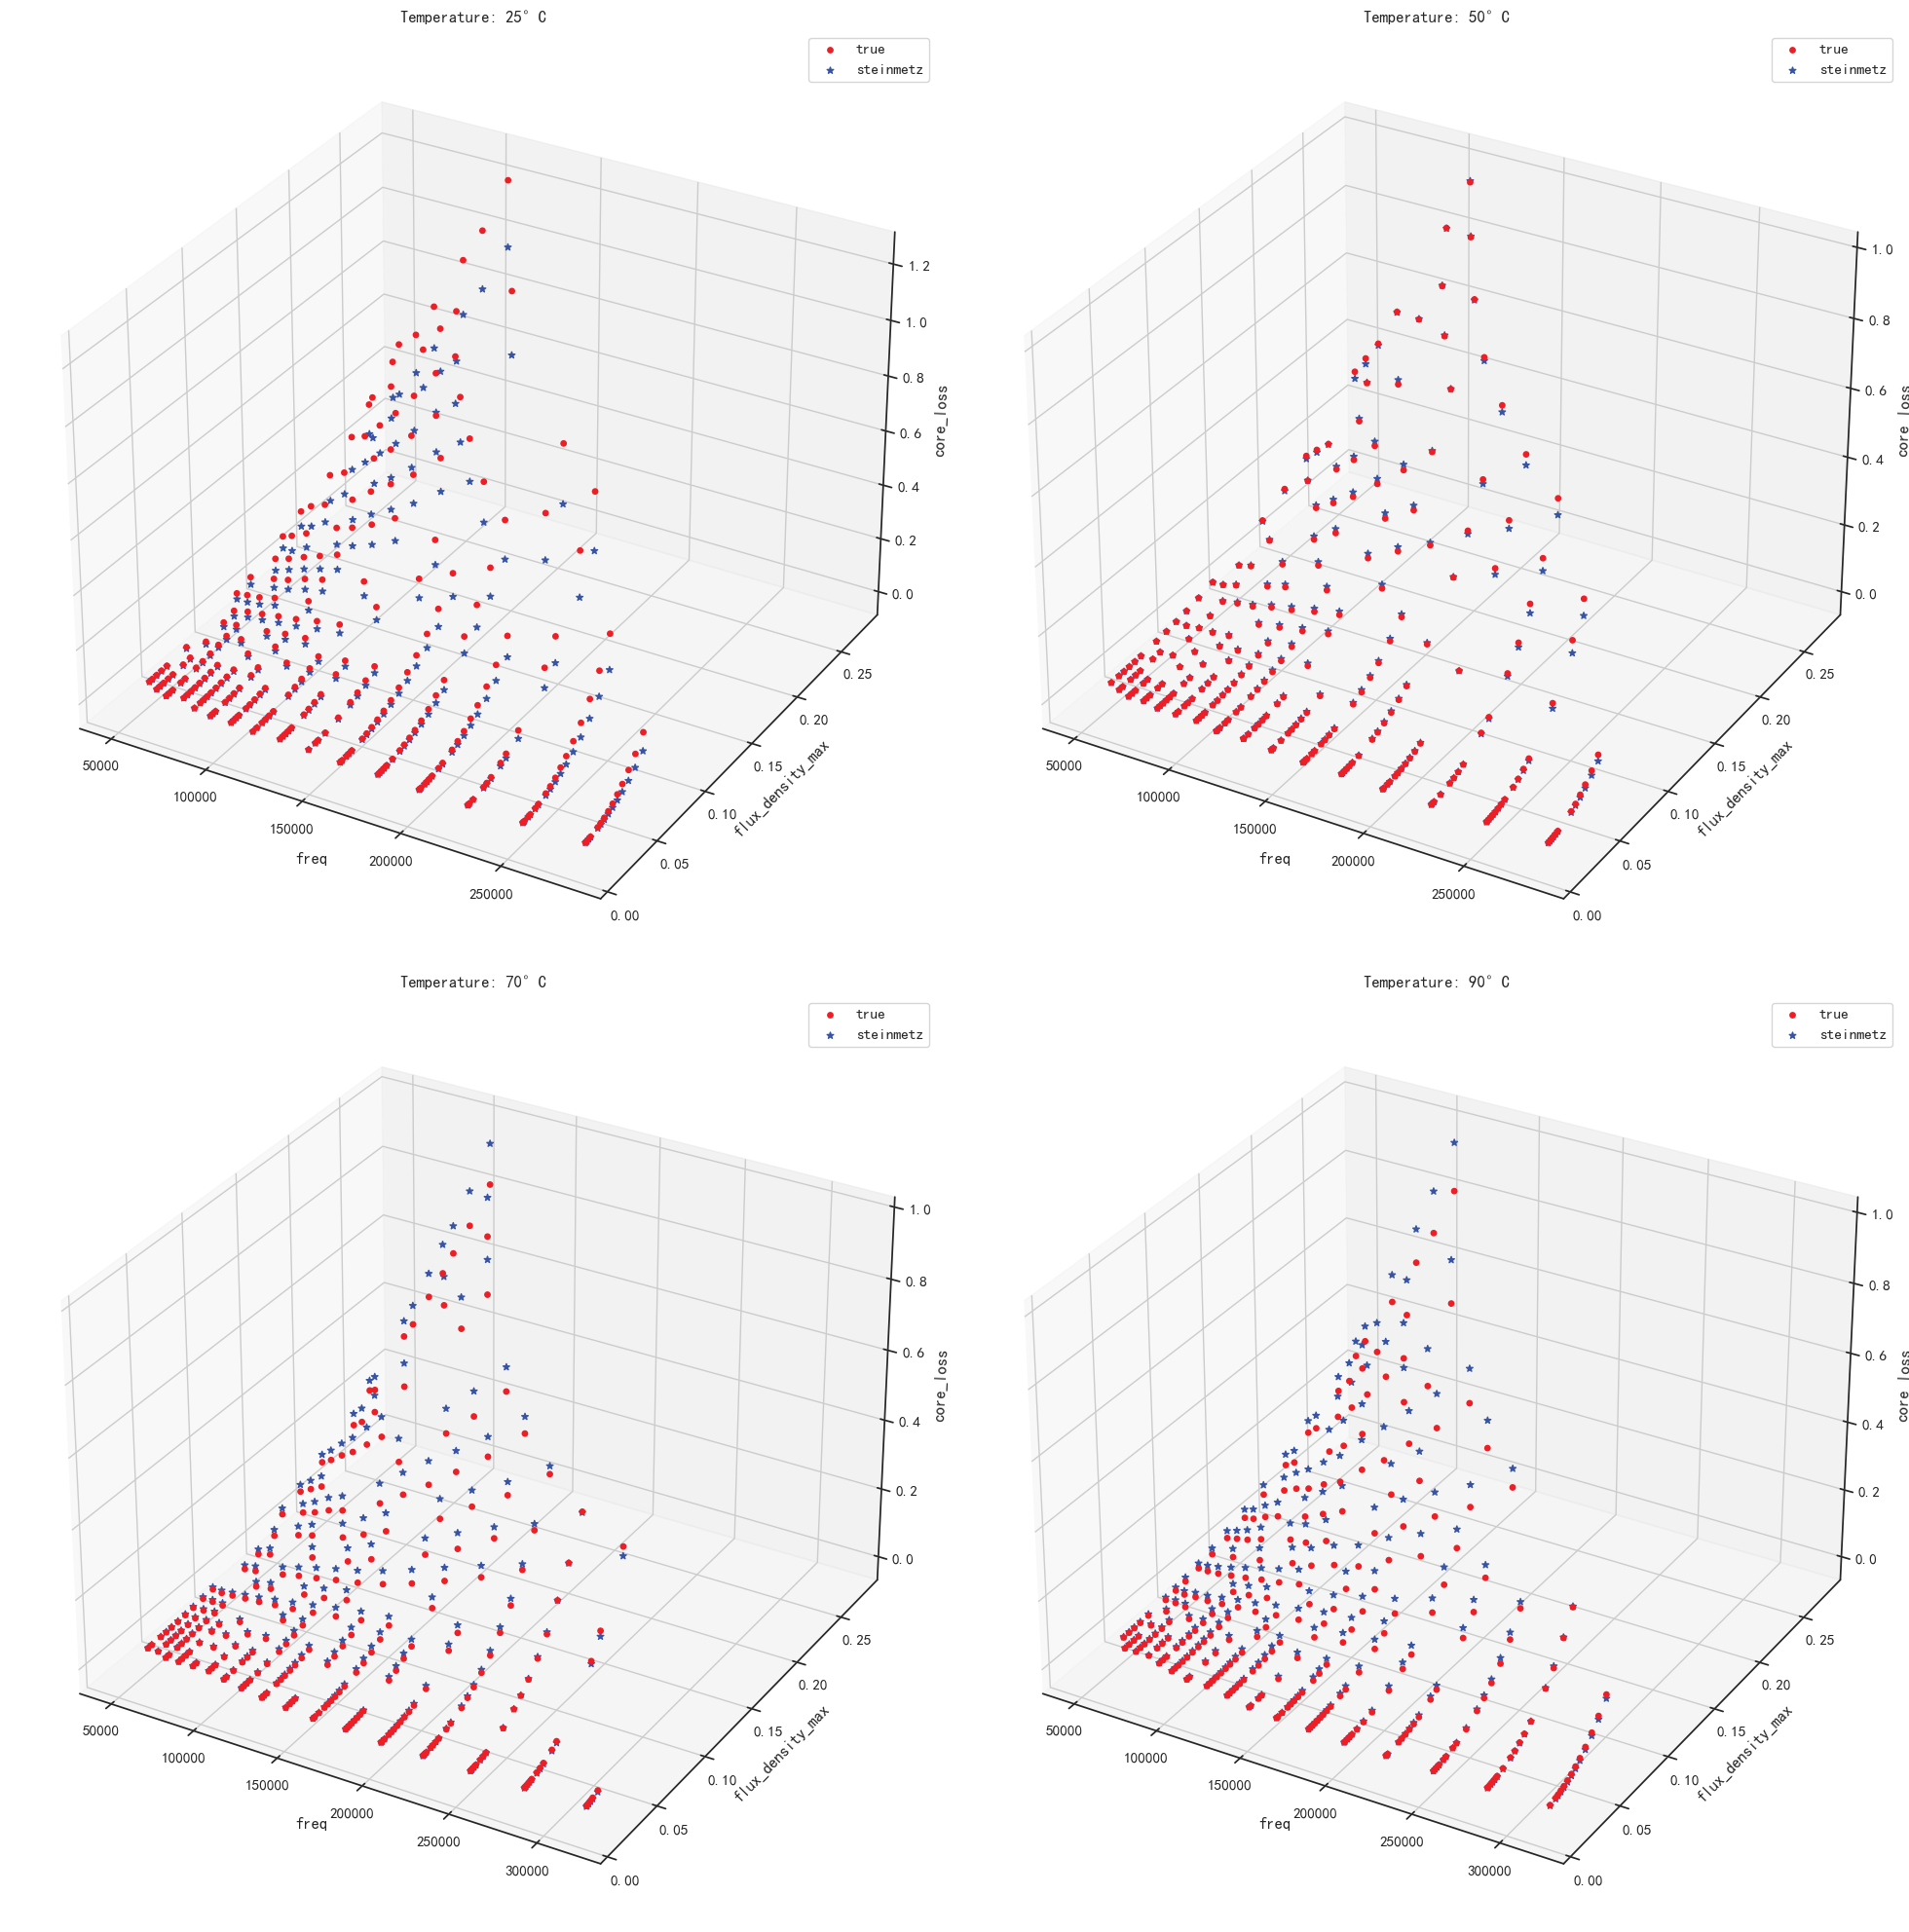

In [19]:
# %matplotlib qt5
fig, axs = plt.subplots(2, 2, figsize=(20, 20),
                        subplot_kw={'projection': '3d'})
temperatures = [25, 50, 70, 90]

for i, temp in enumerate(temperatures):
    ax = axs[i // 2, i % 2]
    df_temp = df[df['temp'] == temp]

    # plot true values in green
    ax.scatter(df_temp['freq'], df_temp['flux_density_max'], df_temp['core_loss'],
               c='#ed1e25', label='true', marker='o', s=15, alpha=1)

    # plot Steinmetz equation predictions in black
    ax.scatter(df_temp['freq'], df_temp['flux_density_max'], df_temp['core_loss_steinmetz'],
               c='#3753a4', label='steinmetz', marker='*', s=25, alpha=1)

    print(temp,
          (df_temp['core_loss'] - df_temp['core_loss_steinmetz']).mean(),
          (df_temp['core_loss'] - df_temp['core_loss_steinmetz']).std()
          )

    ax.set_xlabel('freq')
    ax.set_ylabel('flux_density_max')
    ax.set_zlabel('core_loss')
    ax.set_title(f'Temperature: {temp}°C')
    ax.legend()

plt.tight_layout()
plt.show()

In [20]:
# t-sne
from sklearn.manifold import TSNE

features = df[['freq', 'flux_density_max']].values
tsne = TSNE(n_components=1, random_state=42)
tsne_features = tsne.fit_transform(features)
df['tsne'] = tsne_features

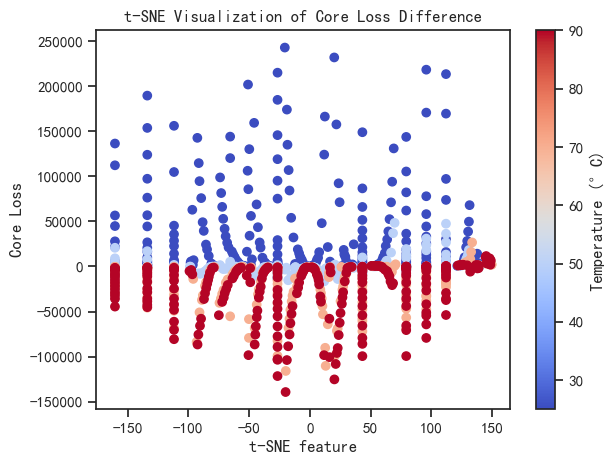

In [21]:
plt.scatter(df['tsne'], df['core_loss'] - df['core_loss_steinmetz'],
            c=df['temp'], cmap='coolwarm')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('t-SNE feature')
plt.ylabel('Core Loss')
plt.title('t-SNE Visualization of Core Loss Difference')
plt.tight_layout()
plt.show()

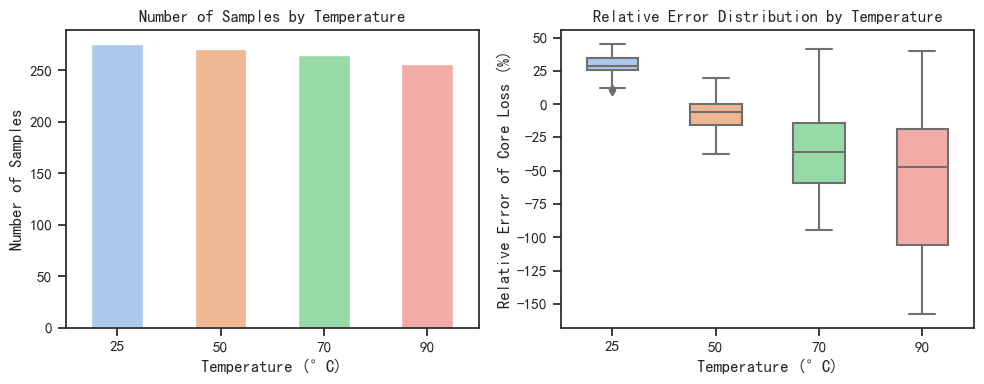

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df['relative_error'] = ((df['core_loss'] - df['core_loss_steinmetz']) / df['core_loss']) * 100
sns.boxplot(data=df,
            x="temp",
            y="relative_error", width=.5, ax=axes[1])
axes[1].set_ylabel("Relative Error of Core Loss (%)")
axes[1].set_xlabel("Temperature (°C)")
axes[1].set_title("Relative Error Distribution by Temperature")

sns.barplot(x=df['temp'].unique(),
            y=df['temp'].value_counts(), width=.5, ax=axes[0])
axes[0].set_ylabel("Number of Samples")
axes[0].set_xlabel("Temperature (°C)")
axes[0].set_title("Number of Samples by Temperature")
plt.tight_layout()
plt.show()

## 尝试

In [23]:
def func_exponential(xdata, k, alpha, beta, c):
    # xdata: array-like, shape (n_samples, 3)
    freq, flux_density_max, temp = xdata
    return k * freq ** alpha * flux_density_max ** beta * (np.exp(c * temp))


def func_logarithmic(xdata, k, alpha, beta, c):
    # xdata: array-like, shape (n_samples, 3)
    freq, flux_density_max, temp = xdata
    return k * freq ** alpha * flux_density_max ** beta * np.log(1 + c * temp)

C:\Users\84199\AppData\Local\Temp\ipykernel_70428\3219428542.py:23: RuntimeWarning: overflow encountered in power
  return k * freq ** alpha * flux_density_max ** beta * (1 / (temp)) ** c
C:\Users\84199\AppData\Local\Temp\ipykernel_70428\3219428542.py:23: RuntimeWarning: invalid value encountered in multiply
  return k * freq ** alpha * flux_density_max ** beta * (1 / (temp)) ** c
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


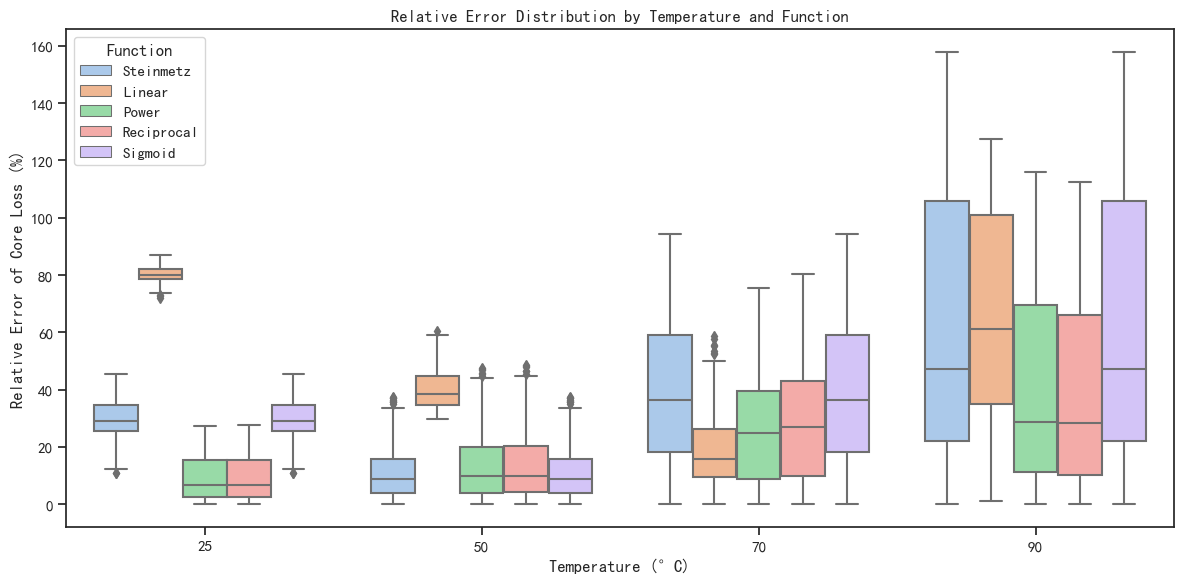

In [24]:
def func_steinmetz(xdata, k, alpha, beta):
    freq, flux_density_max, _ = xdata
    return k * freq ** alpha * flux_density_max ** beta


def func_additive(xdata, k1, alpha, beta, k2):
    freq, flux_density_max, temp = xdata
    return k1 * freq ** alpha * flux_density_max ** beta + k2 * temp


def func_linear(xdata, k, alpha, beta, c):
    freq, flux_density_max, temp = xdata
    return k * freq ** alpha * flux_density_max ** beta * (c * temp)


def func_power(xdata, k, alpha, beta, c1, c2):
    freq, flux_density_max, temp = xdata
    return k * freq ** alpha * flux_density_max ** beta * (1 + c1 * temp + c2 * temp ** 2)


def func_reciprocal(xdata, k, alpha, beta, c):
    freq, flux_density_max, temp = xdata
    return k * freq ** alpha * flux_density_max ** beta * (1 / (temp)) ** c


def func_sigmoid(xdata, k, alpha, beta, c, d):
    freq, flux_density_max, temp = xdata
    return k * freq ** alpha * flux_density_max ** beta * (1 / (1 + np.exp(-(c * temp + d))))


# curve fitting for all functions
xdata = df[['freq', 'flux_density_max', 'temp']].values.T
ydata = df['core_loss'].values

functions = [
    ('Steinmetz', func_steinmetz),
    # ('Additive', func_additive),
    ('Linear', func_linear),
    ('Power', func_power),
    ('Reciprocal', func_reciprocal),
    ('Sigmoid', func_sigmoid)
]

results = {}
for name, func in functions:
    try:
        popt, _ = curve_fit(func, xdata, ydata)
        df[f'core_loss_{name.lower()}'] = func(xdata, *popt)
        df[f'relative_error_{name.lower()}'] = (np.abs(df['core_loss'] - df[f'core_loss_{name.lower()}']) / df['core_loss']) * 100
    except Exception as e:
        print(f"Failed to fit {name} function: {str(e)}")

# create a new dataframe for plotting
plot_df = pd.DataFrame()
for name, _ in functions:
    temp_df = df[['temp', f'relative_error_{name.lower()}']].copy()
    temp_df['Function'] = name
    temp_df.rename(columns={f'relative_error_{name.lower()}': 'Relative Error'}, inplace=True)
    plot_df = pd.concat([plot_df, temp_df], ignore_index=True)

# plot boxplot with hue as different functions
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='temp', y='Relative Error', hue='Function')
plt.ylabel("Relative Error of Core Loss (%)")
plt.xlabel("Temperature (°C)")
plt.title("Relative Error Distribution by Temperature and Function")
plt.legend(title='Function')
plt.tight_layout()
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:488: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


R^2 score for Steinmetz function: 0.9447856220579537
R^2 score for Exponential function: 0.9928834580695565
R^2 score for Logarithmic function: 0.944144971955659
R^2 score for Additive function: 0.9503425671946024
R^2 score for Linear function: 0.6085516901526671
R^2 score for Power function: 0.9954564111582123
R^2 score for Reciprocal function: 0.9953286750526619
R^2 score for Sigmoid function: 0.9447856220571068


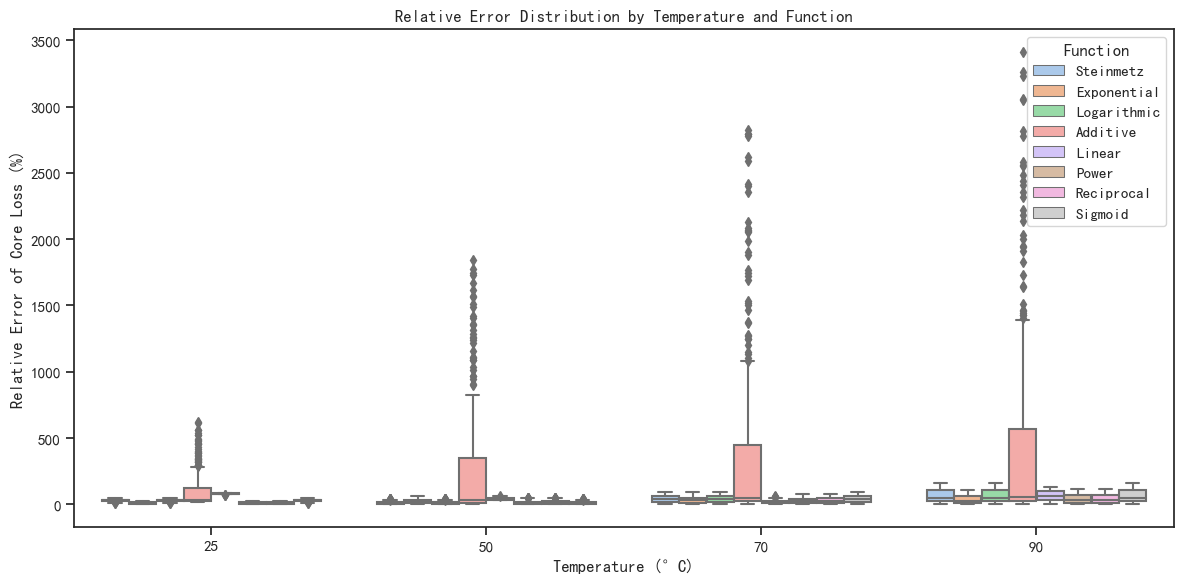

In [30]:
# ... existing code ...

from sklearn.metrics import r2_score

# curve fitting for all functions
xdata = df[['freq', 'flux_density_max', 'temp']].values.T
ydata = df['core_loss'].values

functions = [
    ('Steinmetz', func_steinmetz),
    ('Exponential', func_exponential),
    ('Logarithmic', func_logarithmic),
    ('Additive', func_additive),
    ('Linear', func_linear),
    ('Power', func_power),
    ('Reciprocal', func_reciprocal),
    ('Sigmoid', func_sigmoid)
]

results = {}
r2_scores = {}
for name, func in functions:
    try:
        popt, _ = curve_fit(func, xdata, ydata, maxfev=10000)  # 增加maxfev参数
        df[f'core_loss_{name.lower()}'] = func(xdata, *popt)
        df[f'relative_error_{name.lower()}'] = (np.abs(df['core_loss'] - df[f'core_loss_{name.lower()}']) / df['core_loss']) * 100
        
        # Calculate R^2 score
        r2 = r2_score(ydata, df[f'core_loss_{name.lower()}'])
        r2_scores[name] = r2
    except Exception as e:
        print(f"Failed to fit {name} function: {str(e)}")

# Print R^2 scores
for name, r2 in r2_scores.items():
    print(f"R^2 score for {name} function: {r2}")

# create a new dataframe for plotting
plot_df = pd.DataFrame()
for name, _ in functions:
    temp_df = df[['temp', f'relative_error_{name.lower()}']].copy()
    temp_df['Function'] = name
    temp_df.rename(columns={f'relative_error_{name.lower()}': 'Relative Error'}, inplace=True)
    plot_df = pd.concat([plot_df, temp_df], ignore_index=True)

# plot boxplot with hue as different functions
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='temp', y='Relative Error', hue='Function')
plt.ylabel("Relative Error of Core Loss (%)")
plt.xlabel("Temperature (°C)")
plt.title("Relative Error Distribution by Temperature and Function")
plt.legend(title='Function')
plt.tight_layout()
plt.show()